In [21]:
#modules
import os
import random
import time


import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.image import read_image_bgr
from matplotlib import pyplot
from numpy import abs
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Task 01
(10pt) Wykonaj zadanie 2 z listy 6 z wykorzystaniem Kerasa i Tensorflow. Wykonaj testy dla kilku funkcji aktywacji oraz dla wielu warstw sieci. Poeksperymentuj!

#### Eksperymenty
Jako eksperymenty zaimplementowałem po prostu algorytm metaheurystyczny local search( hill climbing, tylko po mojemu) na podstawie
zadanego rozwiązania znajduje/ tworzy sieci o minimalnym mse. W poniższym mamy więc tworzenie modelu, z wykresem najlepszego z przeglądanych, ale bez animacji.
Animacja dla jednej z wybranych sieci (scroll down).
Z ograniczeniem do maksymalnie 10 warstw i 10 neuronów w layer.

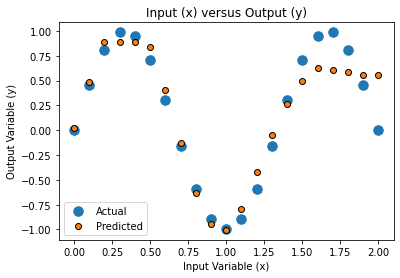

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 9)                 18        
_________________________________________________________________
dense_10 (Dense)             (None, 10)                100       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_12 (Dense)             (None, 10)                40        
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_14 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
def plot_(x, y, scx, scy, model):
    yhat = model.predict(x)
    x_plot = scx.inverse_transform(x)
    y_plot = scy.inverse_transform(y)
    yhat_plot = scy.inverse_transform(yhat)
    pyplot.scatter(x_plot, y_plot, label='Actual', s=90)
    pyplot.scatter(x_plot, yhat_plot, label='Predicted', edgecolors='black')
    pyplot.title('Input (x) versus Output (y)')
    pyplot.xlabel('Input Variable (x)')
    pyplot.ylabel('Output Variable (y)')
    pyplot.legend()
    pyplot.show()


def get_random_model(x, y, ep=500, acts=('tanh', 'relu', 'sigmoid'), krnl_init='he_uniform', in_dim=1, out_dim=1,
                     max_neuron_layer=10,
                     min_neuron_layer=2, layers_number=random.randint(1, 7), ls='mse', opt='adam'):
    model = Sequential()
    model.add(
        Dense(random.randint(min_neuron_layer, max_neuron_layer), input_dim=in_dim, activation=random.choice(acts),
              kernel_initializer=krnl_init))
    for i in range(layers_number):
        neurons = random.randint(min_neuron_layer, max_neuron_layer)
        model.add(
            Dense(neurons, activation=random.choice(acts),
                  kernel_initializer=krnl_init))
    model.add(Dense(out_dim))
    model.compile(loss=ls, optimizer=opt)
    model.fit(x, y, epochs=ep, batch_size=10, verbose=0)
    return model


def get_data(name):
    if 'parabolic' in name:
        x = np.linspace(-50, 50, 26)
        y = x ** 2
    elif 'sinus' in name:
        x = np.linspace(0, 2, 21)
        y = np.sin((3 * np.pi / 2) * x)
    else:
        raise NotImplementedError
    x = x.reshape((len(x), 1))
    y = y.reshape((len(y), 1))
    scale_x = MinMaxScaler()
    x = scale_x.fit_transform(x)
    scale_y = MinMaxScaler()
    y = scale_y.fit_transform(y)
    return x, y, scale_x, scale_y


def learn_parabolic(model):
    x, y, scx, scy = get_data('learn_parabolic')
    yhat = model.predict(x)
    y_plot = scy.inverse_transform(y)
    yhat_plot = scy.inverse_transform(yhat)
    #print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
    return mean_squared_error(y_plot, yhat_plot)


def learn_sinus(model):
    x, y, scx, scy = get_data('learn_sinus')
    yhat = model.predict(x)
    y_plot = scy.inverse_transform(y)
    yhat_plot = scy.inverse_transform(yhat)
    #print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
    return mean_squared_error(y_plot, yhat_plot)


def get_current_time():
    return int(round(time.time() * 1000))


def get_environment(x, y, n=10):
    return [get_random_model(x, y) for _ in range(n)]


def local_search(t, quality):
    end_time = get_current_time() + t * 1000
    x, y, scx, scy = get_data(quality.__name__)
    model = get_random_model(x, y)
    best_solution = model
    while get_current_time() < end_time:
        model = min(get_environment(x, y), key=quality)
        if quality(model) < quality(best_solution):
            best_solution = model
    plot_(x, y, scx, scy, best_solution)
    return best_solution


def main(t, func):
    mod_best = local_search(t, quality=func)
    print(mod_best.summary())
    for layer in mod_best.layers:
        print('['+layer.name, str(layer.activation).split(" ")[1]+']')
    print('\n min mse model=',func(mod_best))

# for example
main(20, learn_sinus)

### Tutaj przykładowe ładne modele z aktywacjami dobranymi przez powyższy local search

#### Multiple Layer

##### Parabolic (multiple layer)

MSE: 2034.042


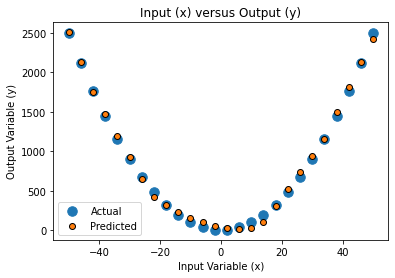

In [3]:
x = np.linspace(-50, 50, 26)
y = x ** 2
x, y = x.reshape((len(x), 1)), y.reshape((len(y), 1))
x_scale, y_scale = MinMaxScaler(), MinMaxScaler()
x, y = x_scale.fit_transform(x), y_scale.fit_transform(y)
model = Sequential()
model.add(Dense(3, input_dim=1, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(9, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(9, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=500, batch_size=10, verbose=0)
yhat = model.predict(x)
x_plot = x_scale.inverse_transform(x)
y_plot = y_scale.inverse_transform(y)
yhat_plot = y_scale.inverse_transform(yhat)
print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
pyplot.scatter(x_plot,y_plot, label='Actual',s=90)
pyplot.scatter(x_plot,yhat_plot, label='Predicted',edgecolors='black')
pyplot.title('Input (x) versus Output (y)')
pyplot.xlabel('Input Variable (x)')
pyplot.ylabel('Output Variable (y)')
pyplot.legend()
pyplot.show()


##### Sinus(multiple layer)

MSE: 0.111


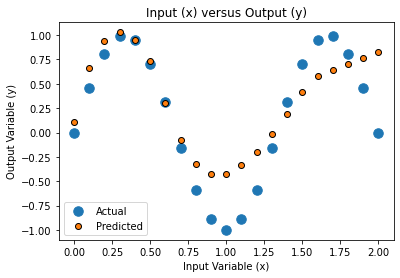

In [4]:

x = np.linspace(0, 2, 21)
y = np.sin((3 * np.pi / 2) * x)
x, y = x.reshape((len(x), 1)), y.reshape((len(y), 1))
x_scale, y_scale = MinMaxScaler(), MinMaxScaler()
x, y = x_scale.fit_transform(x), y_scale.fit_transform(y)
model = Sequential()
model.add(Dense(4, input_dim=1, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(7, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=500, batch_size=10, verbose=0)
yhat = model.predict(x)
x_plot = x_scale.inverse_transform(x)
y_plot = y_scale.inverse_transform(y)
yhat_plot = y_scale.inverse_transform(yhat)
print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
pyplot.scatter(x_plot,y_plot, label='Actual',s=90)
pyplot.scatter(x_plot,yhat_plot, label='Predicted',edgecolors='black')
pyplot.title('Input (x) versus Output (y)')
pyplot.xlabel('Input Variable (x)')
pyplot.ylabel('Output Variable (y)')
pyplot.legend()
pyplot.show()

### 2 layer

##### Parabolic (1-x-1)

MSE: 351084.352


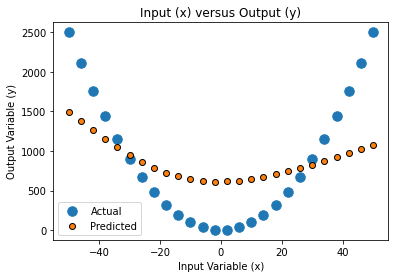

In [5]:
x = np.linspace(-50, 50, 26)
y = x ** 2
x, y = x.reshape((len(x), 1)), y.reshape((len(y), 1))
x_scale, y_scale = MinMaxScaler(), MinMaxScaler()
x, y = x_scale.fit_transform(x), y_scale.fit_transform(y)
model = Sequential()
model.add(Dense(8, input_dim=1, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=500, batch_size=10, verbose=0)
yhat = model.predict(x)
x_plot = x_scale.inverse_transform(x)
y_plot = y_scale.inverse_transform(y)
yhat_plot = y_scale.inverse_transform(yhat)
print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
pyplot.scatter(x_plot,y_plot, label='Actual',s=90)
pyplot.scatter(x_plot,yhat_plot, label='Predicted',edgecolors='black')
pyplot.title('Input (x) versus Output (y)')
pyplot.xlabel('Input Variable (x)')
pyplot.ylabel('Output Variable (y)')
pyplot.legend()
pyplot.show()

##### Sinus(1-x-1)

MSE: 0.391


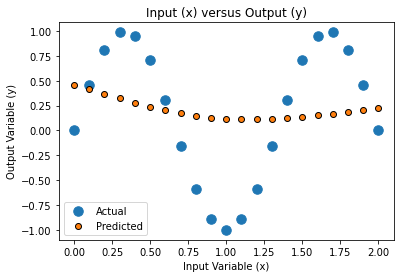

In [6]:
x = np.linspace(0, 2, 21)
y = np.sin((3 * np.pi / 2) * x)
x, y = x.reshape((len(x), 1)), y.reshape((len(y), 1))
x_scale, y_scale = MinMaxScaler(), MinMaxScaler()
x, y = x_scale.fit_transform(x), y_scale.fit_transform(y)
model = Sequential()
model.add(Dense(10, input_dim=1, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=500, batch_size=10, verbose=0)
yhat = model.predict(x)
x_plot = x_scale.inverse_transform(x)
y_plot = y_scale.inverse_transform(y)
yhat_plot = y_scale.inverse_transform(yhat)
print('MSE: %.3f' % mean_squared_error(y_plot, yhat_plot))
pyplot.scatter(x_plot,y_plot, label='Actual',s=90)
pyplot.scatter(x_plot,yhat_plot, label='Predicted',edgecolors='black')
pyplot.title('Input (x) versus Output (y)')
pyplot.xlabel('Input Variable (x)')
pyplot.ylabel('Output Variable (y)')
pyplot.legend()
pyplot.show()

Jak widać sieci wielowarstwowe radzą sobie znacznie lepiej.

### Task 02
(15pt) Wykorzystując architekturę sieci neuronowych RetinaNet Focal Loss for Dense Object Detection zaprogramuj wykrywanie obiektów. Możesz np. skorzystać z implementacji sieci w Kerasie razem z modelem uczonym na danych COCO object detection dataset.

In [7]:
# labels names tez nalezy skompilowac
labels_to_names  = {
    0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane',
    5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light',
    10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench',
    14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow',
    20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack',
    25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee',
    30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite',
    34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard',
    37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass',
    41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl',
    46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli',
    51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake',
    56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed',
    60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse',
    65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave',
    69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book',
    74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear',
    78: 'hair drier', 79: 'toothbrush'} 

#### Zaimportowany model

In [8]:
model_path = 'resnet50_coco_best_v2.1.0.h5'
model_resnet = models.load_model(model_path, backbone_name='resnet50')

def get_model():
    return model_resnet

Using TensorFlow backend.
/home/piotr/Documents/python-course/List07/venv/lib/python3.8/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

### Tutaj wyszukiwanie obiektow na zdjeciach

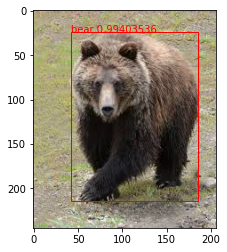

In [9]:
def find_objects(model1,filename,save_figure=False):
    image = read_image_bgr(filename)
    image = preprocess_image(image)
    (image, scale) = resize_image(image)
    image = np.expand_dims(image, axis=0)
    (boxes, scores, labels) = model1.predict_on_batch(image)
    boxes /= scale
    im = np.array(Image.open(filename), dtype=np.uint8)
    fig,ax = plt.subplots(1)
    ax.imshow(im)
    for (box, score, label) in zip(boxes[0], scores[0], labels[0]):
            if score < 0.4:
                continue
            box = box.astype("int")
            rect = patches.Rectangle((box[0],box[1]),abs(box[2]-box[0]),abs(box[3]-box[1]),linewidth=1,edgecolor='r'
                                     ,facecolor='none',label='Label')
            ax.add_patch(rect)
            plt.text(box[0],box[1],labels_to_names[label]+' '+str(score),color='red')
    if save_figure:
        plt.savefig(filename)
    else:
        plt.show()

find_objects(get_model(),'images/bear.jpeg')
    

### Tutaj robimy r screenow z camery i na ich podstawie sklejamy movie.mp4  powinnien sie pojawic w folderze z tym notebookiem.

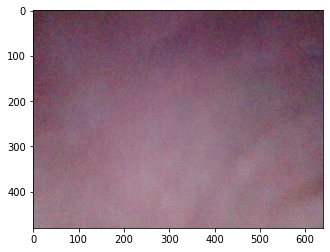

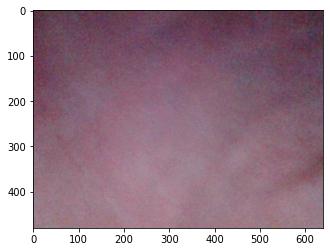

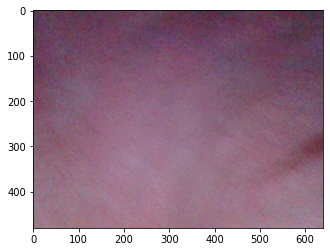

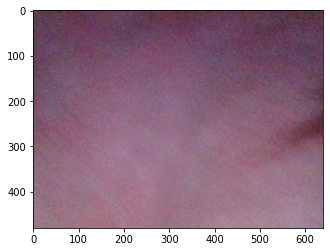

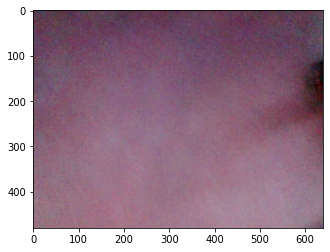

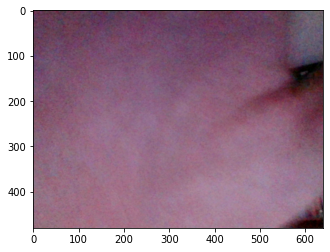

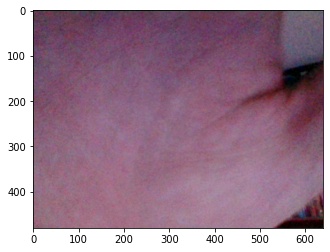

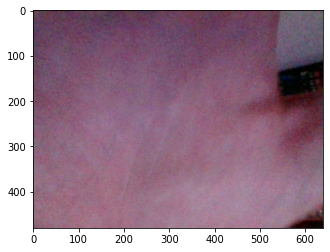

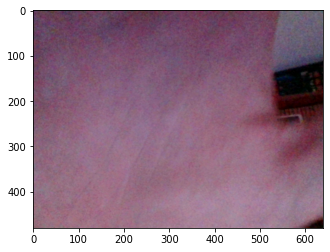

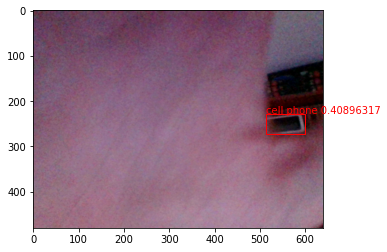

In [18]:
    
def grab_camera_snapshot(camera_id=0, r=3):
    camera = cv2.VideoCapture(camera_id)
    names=[]
    try:
        # bierzemy 15 klatek w praktyce dostajemy lepsze zdjęcia, bo
        # kamera lepiej dobierze kontrast i światło w ostatniej klatce
        for i in range(r):
            snapshot_ok, image = camera.read()
            #cv2.imshow('img',image) # bez tego u mnie nie zapisuja sie zdjecia. (imwrite nie dziala)
            name ='capturedAZSDFGSS_p'+str(i)+'.png'
            names+=[name]
            cv2.imwrite(name,image)
            cv2.destroyAllWindows()
        if not snapshot_ok:
            print("Ups: could not access camera")
    finally:
        camera.release()
        cv2.destroyAllWindows()
    return names

os.system('rm movie.mp4')
group = grab_camera_snapshot(r=10)
for n in group:
    find_objects(get_model(),n,save=True)

def save():
    os.system("ffmpeg -r 1 -i capturedAZSDFGSS_p%01d.png -vcodec mpeg4 -y movie.mp4")
    
def clean():
    os.system('find -type f -name \'*AZSDFGSS*\' -delete')
    
save()
clean()

# Task 03
(20pt) Zapoznaj się z różnymi modelami dostępnymi w Kerasie 
https://keras.io/applications/ oraz wykładem 12
 Wybierz architekturę MobileNet lub Squeeze-and-Excitation network.
  Przeczytaj publikację i samodzielnie zaimplementuj ją w Kerasie.
   Postaraj się uzyskać dobrą wydajność na małych zbiorach danych np.
    [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 

method to unpickle files from cifar-10

In [17]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

z = unpickle('cifar-10-batches-py/data_batch_1')

{b'batch_label': b'training batch 1 of 5', b'labels': [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 

In [25]:
import os

import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.datasets import cifar10

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


def SeparableConv(x, num_filters, strides, alpha=1.0):
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.9997)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(np.floor(num_filters * alpha), kernel_size=(1, 1), strides=strides, use_bias=False,
                               padding='same')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.9997)(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x


def Conv(x, num_filters, kernel_size, strides=1, alpha=1.0):
    x = tf.keras.layers.Conv2D(np.floor(num_filters * alpha), kernel_size=kernel_size, strides=strides, use_bias=False,
                               padding='same')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.9997)(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x


inputs = tf.keras.layers.Input(shape=(32, 32, 3))

x = Conv(inputs, num_filters=32, kernel_size=3, strides=2)
x = SeparableConv(x, num_filters=32, strides=1)
x = Conv(x, num_filters=64, kernel_size=1)
x = SeparableConv(x, num_filters=64, strides=2)
x = Conv(x, num_filters=128, kernel_size=1)
x = SeparableConv(x, num_filters=128, strides=1)
x = Conv(x, num_filters=128, kernel_size=1)
x = SeparableConv(x, num_filters=128, strides=2)
x = Conv(x, num_filters=256, kernel_size=1)
x = SeparableConv(x, num_filters=256, strides=1)
x = Conv(x, num_filters=256, kernel_size=1)
x = SeparableConv(x, num_filters=256, strides=2)
x = Conv(x, num_filters=512, kernel_size=1)

for i in range(5):
    x = SeparableConv(x, num_filters=512, strides=1)
    x = Conv(x, num_filters=512, kernel_size=1)

x = SeparableConv(x, num_filters=512, strides=2)
x = Conv(x, num_filters=1024, kernel_size=1)
x = tf.keras.layers.AveragePooling2D(pool_size=(1, 1))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(10)(x)
outputs = tf.keras.layers.Activation('softmax')(x)

model = tf.keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)
model.evaluate( X_test , Y_test )

TypeError: __init__() missing 1 required positional argument: 'units'